# Example optimisation with stochastic nonlocal modifications and gradient descent

## Imports and prep

In [1]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import (
    load_currents,
    load_winds,
    load_waves,
)
from ship_routing.algorithms import (
    gradient_descent_across_track_left,
    gradient_descent_along_track,
    gradient_descent_time_shift,
    LargeIncrementError,
    InvalidGradientError,
    ZeroGradientsError,
)

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import tqdm

In [3]:
np.random.seed(345)

## Load and plot currents, winds, waves

In [4]:
currents = load_currents(
    data_file="data/currents/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_2021-01_100W-020E_10N-65N.nc"
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.Dataset> Size: 10MB
Dimensions:  (lat: 661, lon: 1321, time: 1)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 8B 2021-01-01
Data variables:
    uo       (time, lat, lon) float32 3MB -0.1356 -0.1479 ... 0.07963 0.05846
    vo       (time, lat, lon) float32 3MB -0.01258 -0.02277 ... 0.2739 0.4073
    speed    (time, lat, lon) float32 3MB 0.1362 0.1497 0.163 ... 0.2852 0.4115
Attributes:
    Conventions:  CF-1.8
    area:         Global
    contact:      https://marine.copernicus.eu/contact
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    institution:  Mercator Ocean International
    licence:      http://marine.copernicus.eu/services-portfolio/service-comm...
    producer:     CMEMS - Global Monitoring and Forecasting Centre
    references:   http://marine.copernicus.eu
    source:       MOI GLO12
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...

In [5]:
winds = load_winds(
    data_file="data/winds/cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H_2021-01_6hours_0.5deg_100W-020E_10N-65N.nc"
)
winds["speed"] = ((winds.to_array() ** 2).sum("variable") ** 0.5).where(
    ~winds.uw.isnull()
)
winds

<xarray.Dataset> Size: 26MB
Dimensions:  (time: 125, lat: 110, lon: 160)
Coordinates:
  * lat      (lat) float32 440B 10.06 10.56 11.06 11.56 ... 63.56 64.06 64.56
  * lon      (lon) float32 640B -99.94 -99.44 -98.94 ... -21.44 -20.94 -20.44
  * time     (time) datetime64[ns] 1kB 2021-01-01 ... 2021-02-01
Data variables:
    uw       (time, lat, lon) float32 9MB 1.77 2.06 1.19 ... -1.06 -0.82 -0.7
    vw       (time, lat, lon) float32 9MB -3.44 -3.66 -4.05 ... 0.15 0.1 -0.26
    speed    (time, lat, lon) float32 9MB 3.869 4.2 4.221 ... 0.8261 0.7467
Attributes: (12/26)
    Conventions:                CF-1.6, ACDD-1.3
    date_created:               2024-03-25T23:58:22
    date_modified:              2024-03-25T23:58:22
    geospatial_lat_max:         89.9375
    geospatial_lat_min:         -89.9375
    geospatial_lat_resolution:  0.125
    ...                         ...
    project:                    Copernicus Marine Service Wind Thematic Assem...
    references:                 Copernicus Marine Service Product User Manual...
    summary:                    Global ocean 10-m stress-equivalent wind and ...
    time_coverage_end:          2023-12-21T23:00:00
    time_coverage_start:        2023-12-21T23:00:00
    title:                       Global Ocean - Wind and Stress - Hourly - Re...

In [6]:
waves = load_waves(
    data_file="data/waves/cmems_mod_glo_wav_my_0.2deg_PT3H-i_VHM0_2021-01_1d-max_100W-020E_10N-65N.nc"
)

waves

<xarray.Dataset> Size: 14MB
Dimensions:  (lat: 276, lon: 401, time: 32)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.2 10.4 10.6 10.8 ... 64.4 64.6 64.8 65.0
  * lon      (lon) float32 2kB -100.0 -99.8 -99.6 -99.4 ... -20.4 -20.2 -20.0
  * time     (time) datetime64[ns] 256B 2001-01-01T12:00:00 ... 2001-02-01T12...
Data variables:
    wh       (time, lat, lon) float32 14MB ...

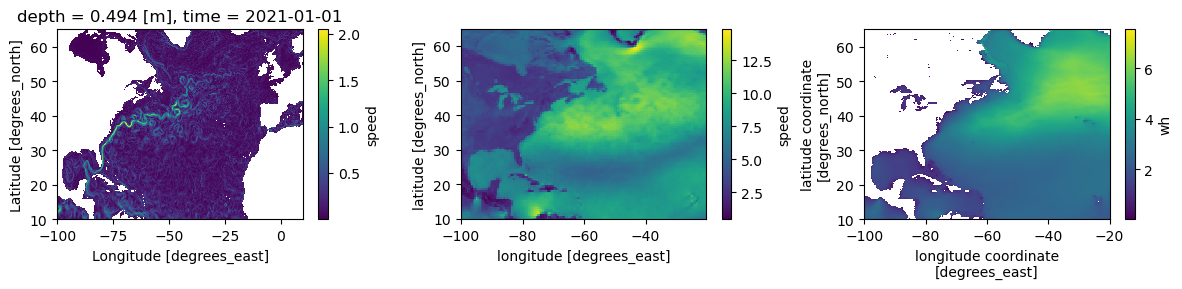

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

currents.speed.plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

fig.tight_layout();

## Define a route and have a look

In [8]:
route_0 = Route(
    way_points=(
        WayPoint(lon=-80.5, lat=30, time=np.datetime64("2021-01-01")),
        WayPoint(lon=-10, lat=50, time=np.datetime64("2021-01-11")),
    )
)
# refine to 12 hourly way points
refine_to = np.mean([l.speed_ms for l in route_0.legs]) * 12 * 3600.0
route_0 = route_0.refine(distance_meters=refine_to)
route_0

Route(way_points=(WayPoint(lon=-80.5, lat=30, time=numpy.datetime64('2021-01-01')), WayPoint(lon=-78.098519636058, lat=31.855837618895183, time=numpy.datetime64('2021-01-01T11:59:59.999')), WayPoint(lon=-75.60015737467967, lat=33.6639713948614, time=numpy.datetime64('2021-01-01T23:59:59.999')), WayPoint(lon=-72.99663283537555, lat=35.41896272444271, time=numpy.datetime64('2021-01-02T11:59:59.999')), WayPoint(lon=-70.27967718012803, lat=37.11487954484631, time=numpy.datetime64('2021-01-02T23:59:59.999')), WayPoint(lon=-67.44123126301778, lat=38.74527014071479, time=numpy.datetime64('2021-01-03T11:59:59.999')), WayPoint(lon=-64.47371094073974, lat=40.303149089749574, time=numpy.datetime64('2021-01-03T23:59:59.999')), WayPoint(lon=-61.37034871434607, lat=41.78100113563067, time=numpy.datetime64('2021-01-04T11:59:59.999')), WayPoint(lon=-58.12561687605418, lat=43.170809951530096, time=numpy.datetime64('2021-01-04T23:59:59.999')), WayPoint(lon=-54.73572989755354, lat=44.46411963593293, time

In [9]:
print("speed (m/s)", np.mean([l.speed_ms for l in route_0.legs]))

speed (m/s) 7.134894006504659


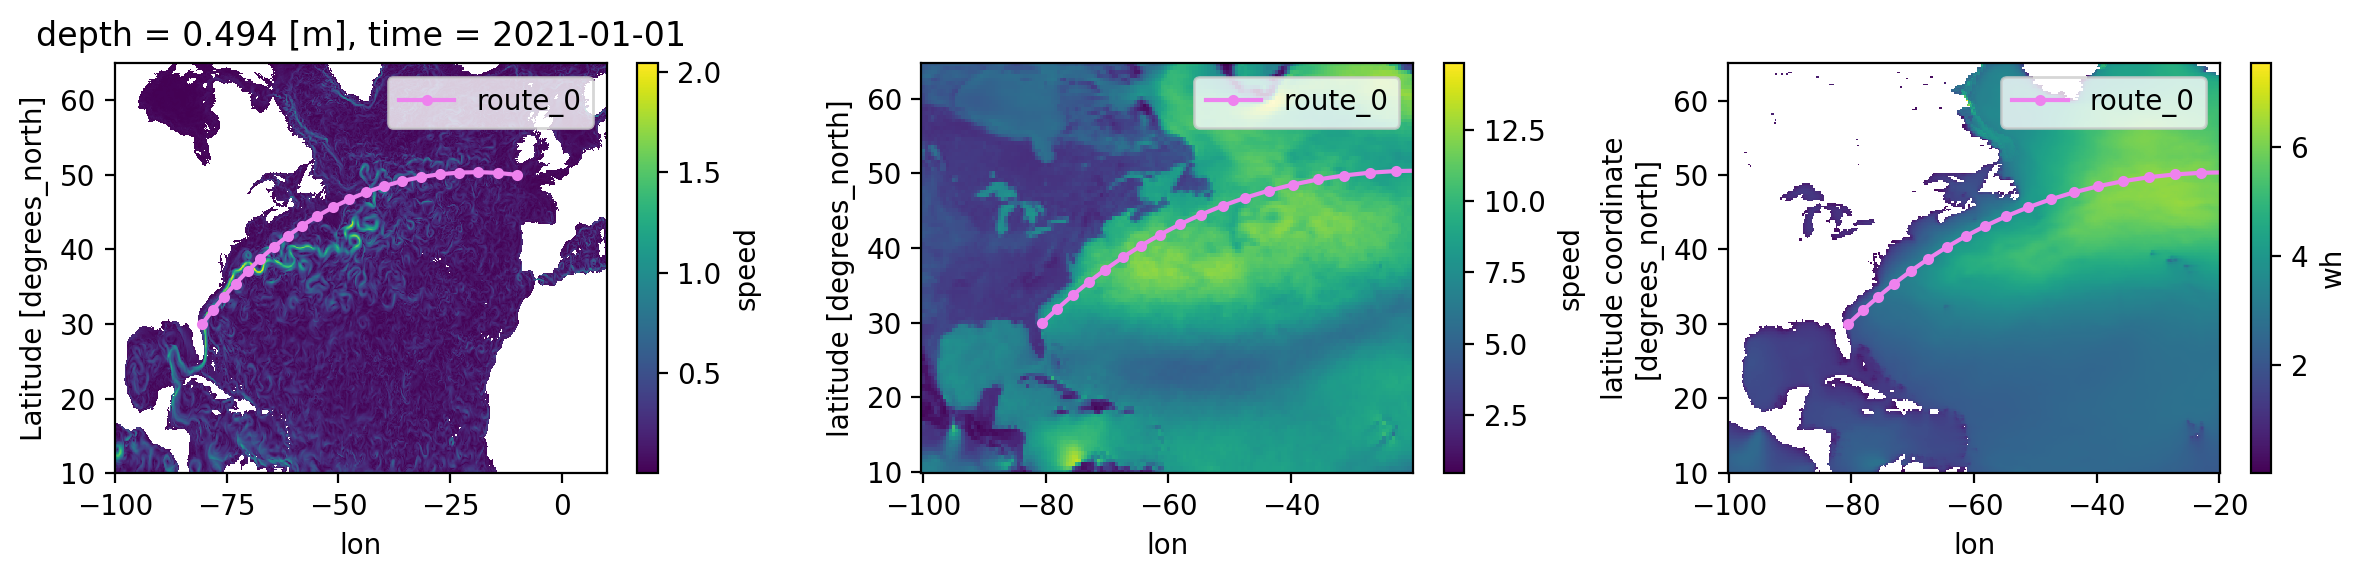

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(200)

currents.speed.plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon", y="lat", marker=".", ax=_ax, color="violet", label="route_0"
    )

fig.tight_layout();

## Keep track of cost

In [11]:
cost_steps = []

## Stochastic Optimisation

In [12]:
max_width = 0.75 * route_0.length_meters
max_dist_mod = 0.75 * max_width
route_1 = route_0
cost = route_1.cost_through(
    current_data_set=currents,
    wave_data_set=waves,
    wind_data_set=winds,
)
cost_steps.append(cost)

accepted = 0
n_reset = 0
for n in tqdm.tqdm(range(200)):
    _route_1 = route_1.move_waypoints_left_nonlocal(
        center_distance_meters=np.random.uniform(
            max_width / 2.0, route_1.length_meters - max_width / 2.0
        ),
        width_meters=max_width,
        max_move_meters=np.random.uniform(-max_dist_mod, max_dist_mod),
    )
    _cost = _route_1.cost_through(
        current_data_set=currents,
        wave_data_set=waves,
        wind_data_set=winds,
    )
    if not np.isnan(_cost) and _cost < cost:
        route_1 = _route_1
        cost = _cost
        accepted += 1
        cost_steps.append(cost)
    if (accepted + 1) / (n_reset + 1) < 0.05:
        n_reset = 0
        accepted = 0
        max_dist_mod /= 2.0**0.5
        max_width /= 2.0**0.5
        print(".")
    n_reset += 1

 10%|████▍                                     | 21/200 [00:05<00:49,  3.65it/s]

.


 40%|█████████████████                         | 81/200 [00:22<00:32,  3.63it/s]

.


 50%|████████████████████▋                    | 101/200 [00:27<00:27,  3.62it/s]

.


100%|█████████████████████████████████████████| 200/200 [00:55<00:00,  3.63it/s]


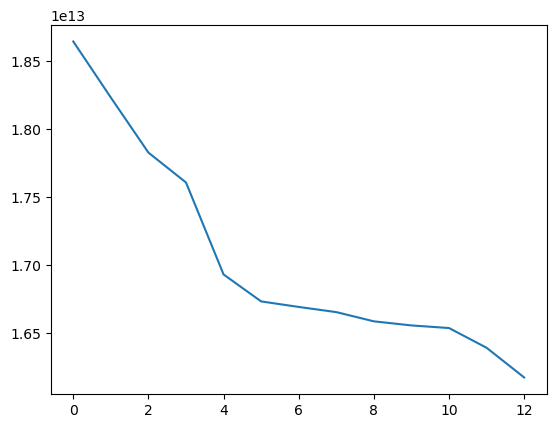

In [13]:
plt.plot(cost_steps)

## Show results

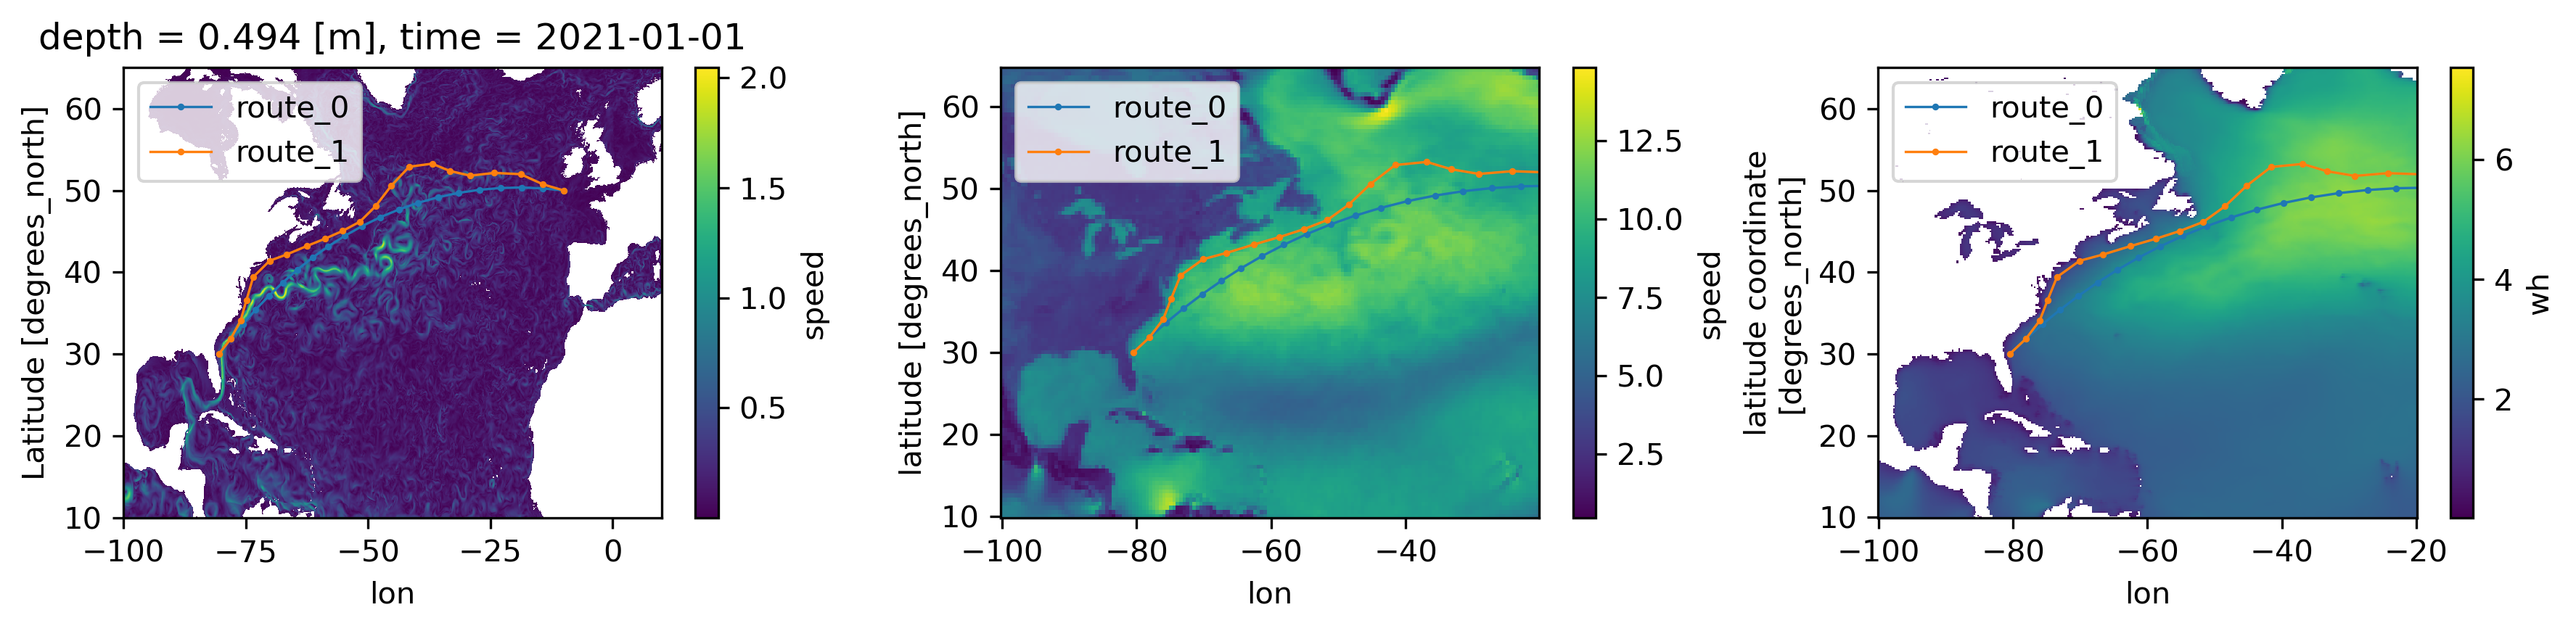

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(300)

currents.speed.plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon",
        y="lat",
        marker=".",
        markersize=2.5,
        ax=_ax,
        label="route_0",
        linewidth=0.8,
    )
    route_1.data_frame.plot.line(
        x="lon",
        y="lat",
        marker=".",
        markersize=2.5,
        ax=_ax,
        label="route_1",
        linewidth=0.8,
    )

fig.tight_layout();

In [15]:
print(
    "reduction",
    (route_1.cost_through(currents) - route_0.cost_through(currents))
    / route_0.cost_through(currents)
    * 100.0,
    "%",
)

reduction 18.586161884306687 %


In [16]:
print(
    "length +",
    (route_1.length_meters - route_0.length_meters) / route_0.length_meters * 100.0,
    "%",
)

length + 5.220196995307457 %


## Gradient descents

In [17]:
learning_rate_percent_time = 0.2
time_increment = 1_200
learning_rate_percent_along = 0.2
dist_shift_along = 10_000
learning_rate_percent_across = 0.2
dist_shift_across = 10_000

route_2 = route_1
cost_steps_grad = []

for n in tqdm.tqdm(range(20)):
    try:
        route_2 = gradient_descent_time_shift(
            route=route_2,
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
            time_shift_seconds=time_increment,
            learning_rate_percent=learning_rate_percent_time,
        )
        cost_steps_grad.append(
            route_2.cost_through(
                current_data_set=currents,
                wave_data_set=waves,
                wind_data_set=winds,
            )
        )
    except ZeroGradientsError:
        # converged, just pass
        pass
    except InvalidGradientError:
        time_increment /= 2.0
        learning_rate_percent_time /= 2.0
    except LargeIncrementError:
        learning_rate_percent_time /= 2.0

    try:
        route_2 = gradient_descent_across_track_left(
            route=route_2,
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
            distance_meters=dist_shift_across,
            learning_rate_percent=learning_rate_percent_across,
        )
        cost_steps_grad.append(
            route_2.cost_through(
                current_data_set=currents,
                wave_data_set=waves,
                wind_data_set=winds,
            )
        )
    except ZeroGradientsError:
        # converged, just pass
        pass
    except InvalidGradientError:
        dist_shift_across /= 2.0
        learning_rate_percent_across /= 2.0
    except LargeIncrementError:
        learning_rate_percent_across /= 2.0

    try:
        route_2 = gradient_descent_along_track(
            route=route_2,
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
            distance_meters=dist_shift_along,
            learning_rate_percent=learning_rate_percent_along,
        )
        cost_steps_grad.append(
            route_2.cost_through(
                current_data_set=currents,
                wave_data_set=waves,
                wind_data_set=winds,
            )
        )
    except ZeroGradientsError:
        # converged, just pass
        pass
    except InvalidGradientError:
        dist_shift_along /= 2.0
        learning_rate_percent_along /= 2.0
    except LargeIncrementError:
        learning_rate_percent_along /= 2.0

100%|███████████████████████████████████████████| 20/20 [11:01<00:00, 33.07s/it]


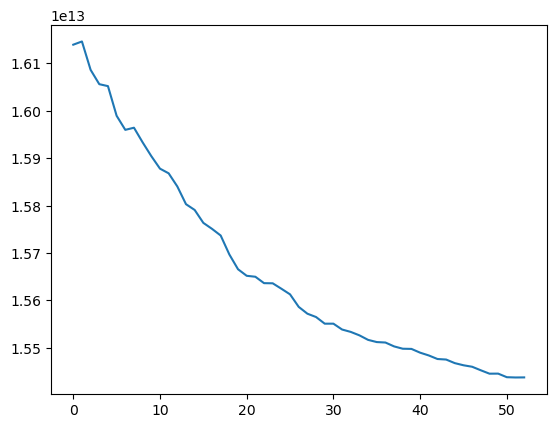

In [18]:
plt.plot(cost_steps_grad)

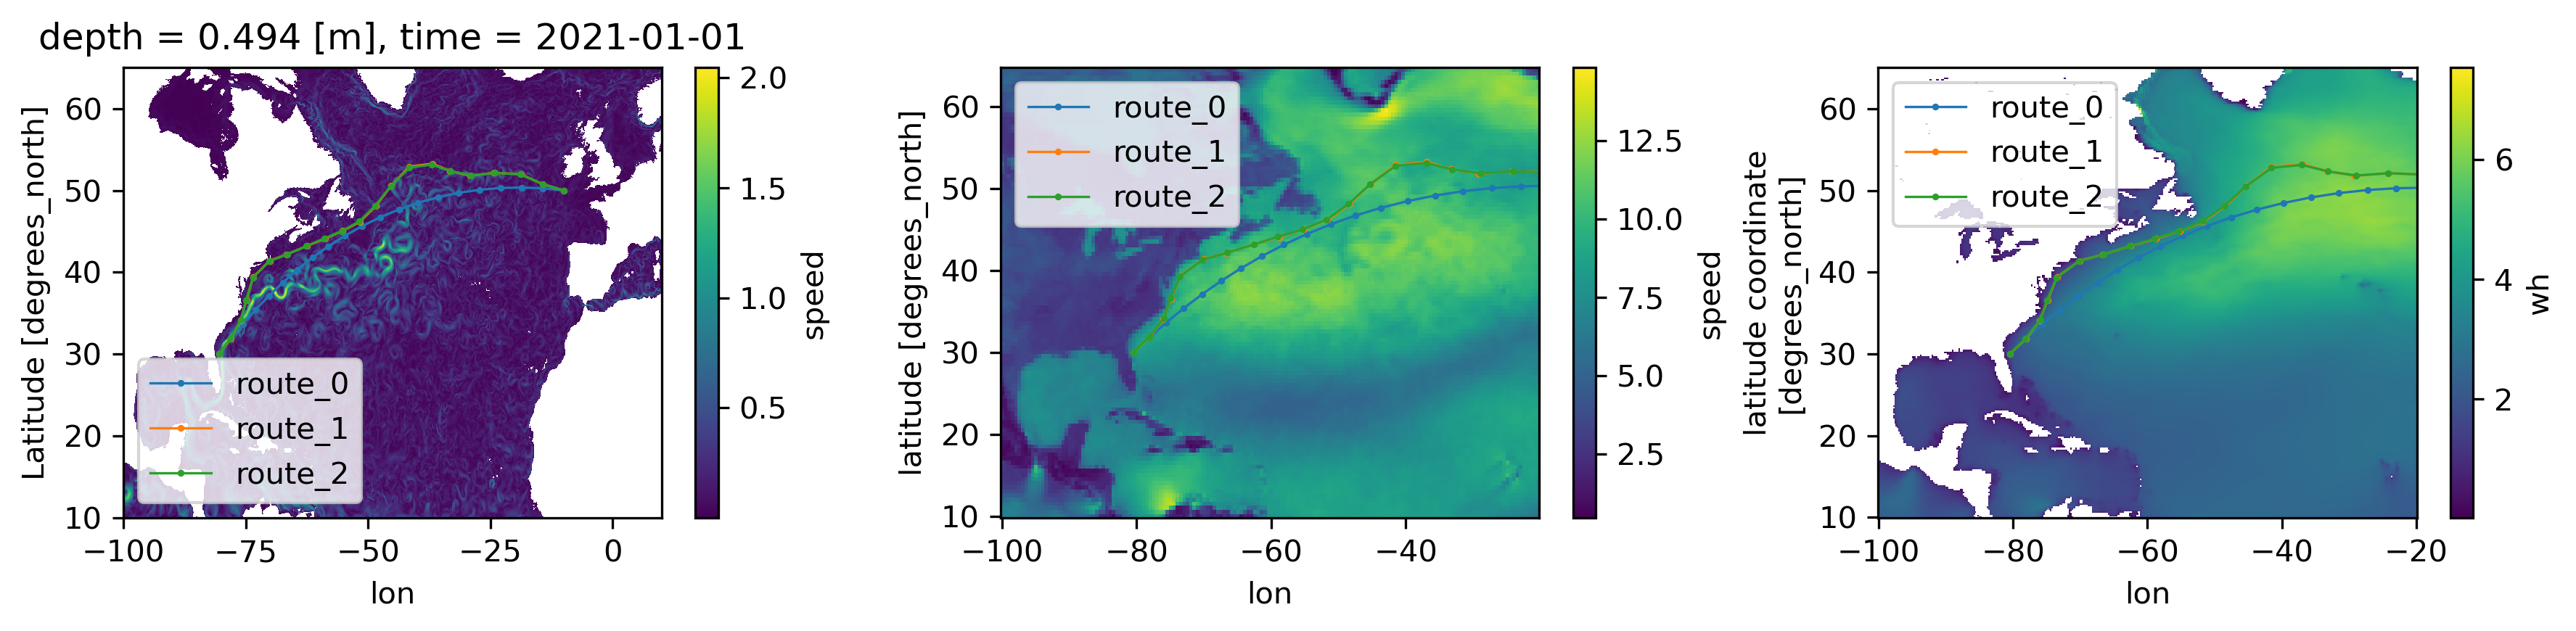

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(300)

currents.speed.plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon",
        y="lat",
        marker=".",
        markersize=2.5,
        ax=_ax,
        label="route_0",
        linewidth=0.8,
    )
    route_1.data_frame.plot.line(
        x="lon",
        y="lat",
        marker=".",
        markersize=2.5,
        ax=_ax,
        label="route_1",
        linewidth=0.8,
    )
    route_2.data_frame.plot.line(
        x="lon",
        y="lat",
        marker=".",
        markersize=2.5,
        ax=_ax,
        label="route_2",
        linewidth=0.8,
    )

fig.tight_layout();

In [22]:
print(
    "reduction w.r.t. initial route",
    (
        route_2.cost_through(
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
        )
        - route_0.cost_through(
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
        )
    )
    / route_0.cost_through(
        current_data_set=currents,
        wave_data_set=waves,
        wind_data_set=winds,
    )
    * 100.0,
    "%",
)

reduction w.r.t. initial route -17.200755987076707 %


In [23]:
print(
    "length  w.r.t. initial route +",
    (route_2.length_meters - route_0.length_meters) / route_0.length_meters * 100.0,
    "%",
)

length  w.r.t. initial route + 4.826253686311445 %


In [25]:
print(
    "reduction w.r.t. stochastic opt route",
    (
        route_2.cost_through(
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
        )
        - route_1.cost_through(
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
        )
    )
    / route_1.cost_through(
        current_data_set=currents,
        wave_data_set=waves,
        wind_data_set=winds,
    )
    * 100.0,
    "%",
)

reduction w.r.t. stochastic opt route -4.527865439721964 %


In [26]:
print(
    "length  w.r.t. stochastic opt route +",
    (route_2.length_meters - route_1.length_meters) / route_1.length_meters * 100.0,
    "%",
)

length  w.r.t. stochastic opt route + -0.3743989464433146 %
